# Introduction

This is first part of an experiment to investigate potential candidates that could be improved in the Testarossa just-in-time compilation pipeline.
The rationale for this experiment grew up from a simple question, "What is the effect of each individual compilation pass on the overall throughput of a program?".
Furthermore, some optimization passes are repeated multiple times in Testarossa's compilation pipeline, what are the effects of optimizations with respect to one another, is the relationship additive or multiplicative?
The general hypothesis is that disabling an optimization will increase the overall amount of time a benchmark iteration would consume, implying a decrease in throughput. 
While the scope of this experiment will likely not answer the questions posed in a meaningful manner, hopefully it provides candidates for improvement when engineering the Testarossa compiler.
These candidates could potentially be a specific optimization which performs poorly across all benchmarks or a single benchmark which benefits from having many optimizations _disabled_.


## Methodology

The [`renaissance`](https://renaissance.dev/) benchmark was chosen as the primary target of this experiment. 
The `renaissance` suite contains representative workloads for the Scala programming language, perhaps containing opportunities for optimization that are not normally present in Java bytecode compiled from Java source.
Alternatively, the `dacapo` benchmark suite was another suitable candidate for the experiment. 

To control for all other variables that could affect the overall result, no other compiler options were tweaked. 
In particular, multi-tier compilation was retained in order to emulate a practical execution scenario.
The number of iterations for each benchmark was kept as the default number of iterations specified by the suite.

The initial rationale on how to collect benchmarking results can be expressed with the following pseudocode.
```
for every optimization of interest:
    for every benchmark in renaissance:
        run benchmark without optimization enabled
```
The implementation of this pseudocode can be found in `scripts/profile_opts.py`

In [1]:
import os 
import os.path
import pandas as pd 

data_directory = "../data/renaissance"
data = []
for filename in os.listdir(data_directory):
    disabled = filename.strip(".csv").split("_")[-1]
    path = os.path.join(data_directory, filename)
    df = pd.read_csv(path)
    df['opt'] = disabled
    data.append(df)

data = pd.concat(data)
data

,benchmark,duration_ns,uptime_ns,vm_start_unix_ms,opt
0,page-rank,5709605283,3890945660,1710908755574,disableNone
1,page-rank,2468225526,11288039813,1710908755574,disableNone
2,page-rank,2547890986,15130122173,1710908755574,disableNone
3,page-rank,2430622440,19085581526,1710908755574,disableNone
4,page-rank,2359198507,22980104946,1710908755574,disableNone
...,...,...,...,...,...
85,finagle-chirper,1253304612,133487277633,1711118442733,disableVirtualGuardTailSplitter
86,finagle-chirper,1246628315,134803758737,1711118442733,disableVirtualGuardTailSplitter
87,finagle-chirper,1267620724,136112661455,1711118442733,disableVirtualGuardTailSplitter
88,finagle-chirper,1243670923,137442334686,1711118442733,disableVirtualGuardTailSplitter


The `duration_ns` is the only column we are interested in, it is the total time taken to run 1 repetition of the benchmark.
We aggregrate the means and standard deviations of the duration samples collected grouped by benchmark and optimization disabled. 
We aren't particularly interested in the results of individual runs; although outliers would be interesting to investigate.

In [2]:
data_means = data.groupby(["opt", "benchmark"]).agg(['mean', 'std'])

We can examine each of the unique optimization candidates for this experiment:

In [3]:
opts = data_means.index.unique(level='opt')
opts

Index(['disableAutoSIMD', 'disableBasicBlockExtension',
       'disableBasicBlockPeephole', 'disableBlockSplitter',
       'disableBlockVersioner', 'disableCFGSimplification',
       'disableCompactLocal', 'disableCompactNullCheck',
       'disableDeadTreeElimination', 'disableEscapeAnalysi', 'disableGLU',
       'disableGlobalCopyPropagation', 'disableGlobalDSE', 'disableGlobalVP',
       'disableIPA', 'disableInlining', 'disableLocalCSE', 'disableLocalDSE',
       'disableLocalReordering', 'disableLocalVP',
       'disableLoopCanonicalization', 'disableNone', 'disableOSR',
       'disablePRBE', 'disablePRE', 'disablePartialInlining',
       'disablePeephole', 'disableSwitchAnalyzer', 'disableTailRecursion',
       'disableTreeCleansing', 'disableVirtualGuardTailSplitter',
       'disableVirtualInlining'],
      dtype='object', name='opt')

We can the ignore the baseline `disableNone` and the inlining optimizations `disableInlining` and `disableVirtualInlining` as their effects on the remainder of the compilation pipeline is extensive.
Disabling inlining optimizations limits the potential for subsequent beneficial transformations.

In [4]:
baseline = data_means.loc['disableNone']
mean = baseline['duration_ns', 'mean']

normalized_data = (data_means['duration_ns', 'mean'] / mean)
normalized_data = normalized_data.drop('disableInlining', level=0).drop('disableNone', level=0).drop('disableVirtualInlining', level=0)

For the sake of making the data easier to read, we normalize the result to be relative to the mean of the baseline.
A normalized value of `1.1` means that the benchmark took `1.1x` the time it took the benchmark to run with no compiler options.

In [5]:
normalized_data.index
normalized_data_by_benchmark = normalized_data.swaplevel()    
normalized_data_by_benchmark

benchmark      opt                            
akka-uct       disableAutoSIMD                    1.024355
als            disableAutoSIMD                    0.997265
chi-square     disableAutoSIMD                    1.004298
db-shootout    disableAutoSIMD                    0.990320
dec-tree       disableAutoSIMD                    1.014603
                                                    ...   
par-mnemonics  disableVirtualGuardTailSplitter    1.039384
philosophers   disableVirtualGuardTailSplitter    0.969414
reactors       disableVirtualGuardTailSplitter    0.980040
scala-doku     disableVirtualGuardTailSplitter    0.998996
scala-kmeans   disableVirtualGuardTailSplitter    1.105910
Name: (duration_ns, mean), Length: 608, dtype: float64

## Results

To find a suitable starting point for investigation, we compute a density distribution of all data points divided into quartiles and displayed as [violin plots](https://en.wikipedia.org/wiki/Violin_plot).
The vast majority of optimizations, when disabled, should result in a greater difference relative to the baseline.
That is, the benchmark should take _longer_ to execute when the optimization is disabled, implying that disabling the optimization has a negative effect on overall program performance.

[Text(0.5, 1.0, 'Density Distribution of Relative Performance of Disabled Optimizations by Benchmark')]

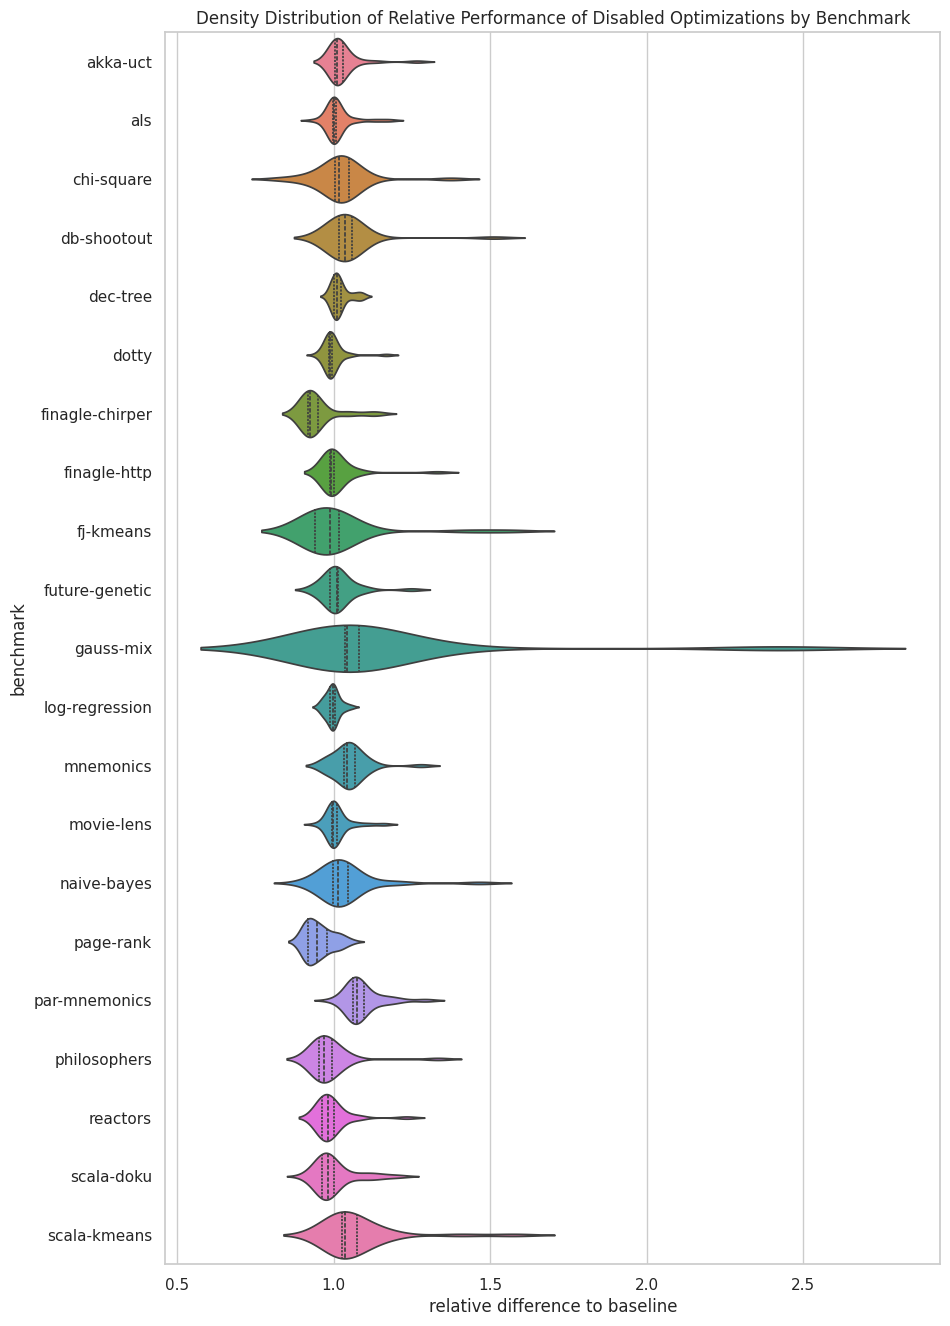

In [6]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
df = normalized_data_by_benchmark.to_frame()
df = df.droplevel(1).droplevel(1,1)

sns.set_theme(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 16))
plt.xlabel("relative difference to baseline")
sns.violinplot(df, x='duration_ns', y ='benchmark', inner='quart', density_norm='count', hue='benchmark').set(title='Density Distribution of Relative Performance of Disabled Optimizations by Benchmark')

From these distributions, we can select individual benchmarks for closer inspection.
For example, we can inspect the `finagle-chirper` benchmark, where 75% of the disabled optimizations resulted in better overall throughput when compared to the baseline, that is the relative difference is less than 1.
`finagle` is a remote procedure framework designed by Twitter and the `finagle-chirper` essentially is a miniature implementation of Twitter.
We can inspect the `finagle-chirper` benchmark in closer detail and the relative difference of disabling each benchmark.

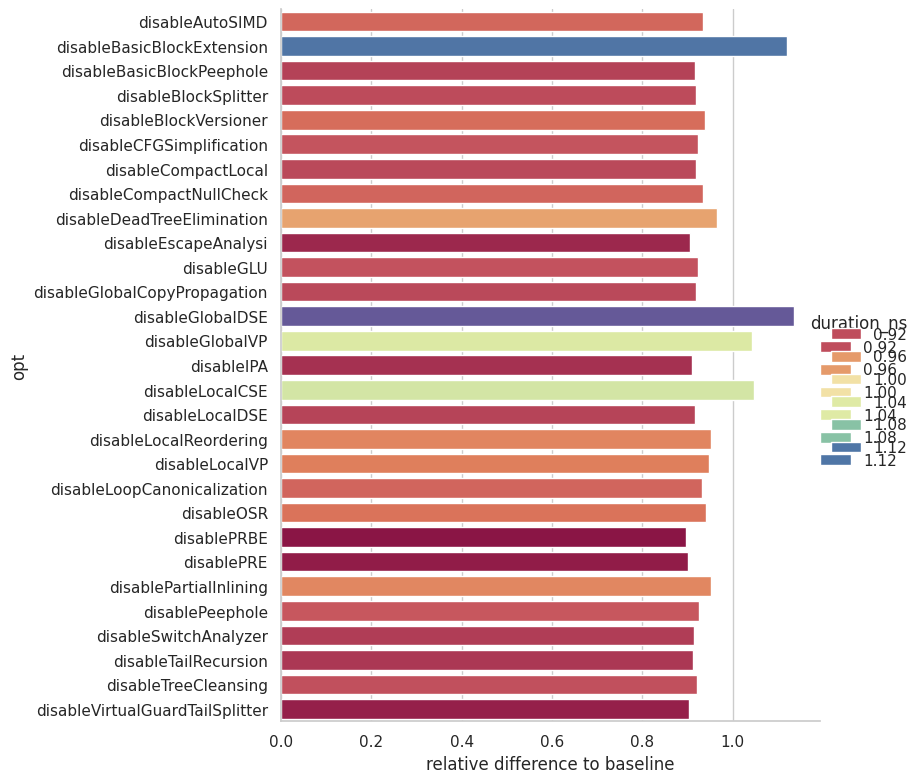

In [7]:
df = normalized_data_by_benchmark.to_frame()
df = df.loc[['finagle-chirper']]
df = df.droplevel(1, 1)
g = sns.catplot(data=df, kind='bar', x='duration_ns', y='opt', hue='duration_ns', palette="Spectral", height=8).set(title='')
plt.xlabel("relative difference to baseline")
g.add_legend()

Alternatively, it would be interesting to see the distributions of each optimization when disabled for every benchmark.
Instead of values by their benchmark, we group the values by their optimization.

<Axes: xlabel='relative difference to baseline', ylabel='opt'>

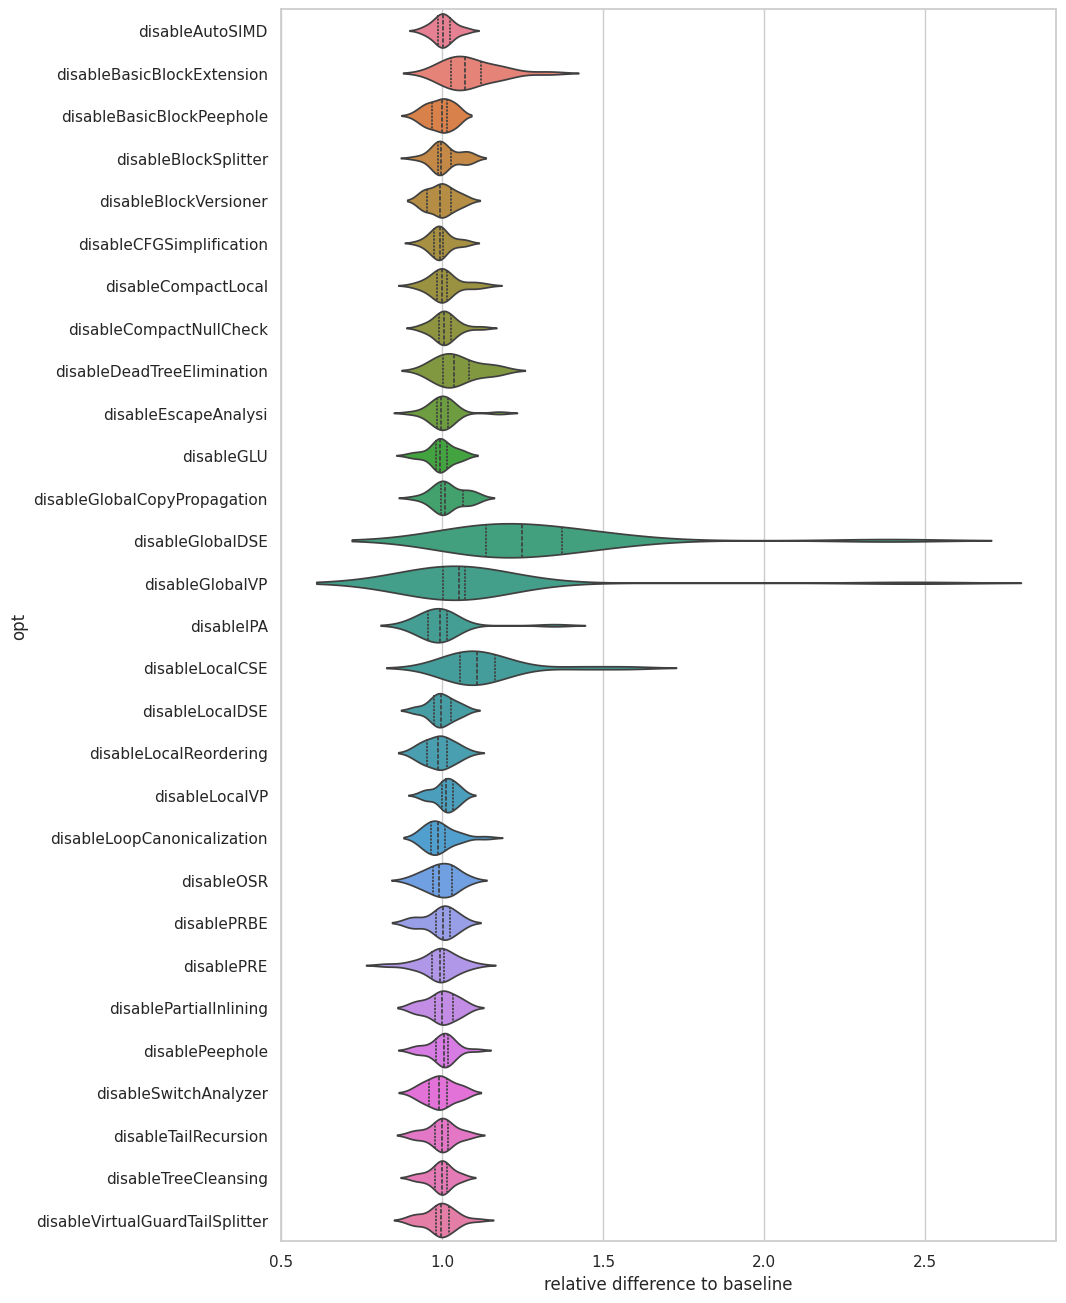

In [8]:
df = normalized_data_by_benchmark.to_frame()
df = df.droplevel(0).droplevel(1,1)

f, ax = plt.subplots(figsize=(10, 16))
plt.xlabel("relative difference to baseline")
sns.violinplot(df, x='duration_ns', y ='opt', inner='quart', density_norm='count', hue='opt')

At first glance, it looks like the disabling a single optimization does not always produce a faster benchmark.
Some optimizations may work better for one workload while being slightly worse on another.
However, some thought should be given to GlobalDSE (Global Dead Store Elimination) and GlobalVP (Global Value Propagation) as the variance in their results is quite drastic. 
In spite of this, the density distribution of the benchmarks grouped by optimization disabled is not too concerning.

This leaves us with a few specific benchmarks that are worth investigating further if there is opportunity to improve optimizations in general for.
But without additional profiling information, it is difficult to reason about _why_ disabling such optimizations for specific benchmarks resulted in better overall performance.
Thus, we leave the investigation of why the majority of optimizations _individually_ produced poorer performance for select benchmarks (`finagle-chirper`, `page-rank`, `philosophers`) for another time (-:

To be continued...